In [1]:
from gensim.models import Word2Vec
import tensorflow as tf
import os
import pickle
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.layers import BatchNormalization

In [2]:
print("Num GPUs: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs:  1


In [ ]:
# Encontra diretorio atual
atual_dir = os.getcwd()

# Acessa arquivo pkl das noticias
parent_dir = os.path.split(atual_dir)

parent_dir = os.path.split(parent_dir[0])

parent_dir = os.path.split(parent_dir[0])

caminho_model_word2vec = os.path.join(parent_dir[0], "Pre-processamento\\model_word2vec.model")

# Carrega o modelo Word2Vec para um arquivo
model_word2vec = Word2Vec.load(caminho_model_word2vec)

In [ ]:
# Carrega o valor de max_length de um arquivo pickle
caminho_max_length = os.path.join(parent_dir[0],"Pre-processamento\\max_length.pkl")
with open(caminho_max_length, 'rb') as f:
    max_length = pickle.load(f)

print("max_length: ", max_length)

max_length:  512


In [ ]:
# Carrega dataframe salvo em formato pickle
caminho_noticias = os.path.join(parent_dir[0],"Pre-processamento\\df_pre_processado.pkl")

with open(caminho_noticias, 'rb') as f:
    df = pickle.load(f)

df

,Texto,Categoria,label
0,"[poder, decidir, expulsar, deputado, federal, ...",Real,1
1,"[bolsonaro, liberal, completo, presidente, psl...",Real,1
2,"[ministro, stf, liberar, Andrea, Neves, prisao...",Real,1
3,"[apesar, abundancia, crescer, preocupacao, pre...",Real,1
4,"[harvard, mit, levarao, dilma, moro, suplicy, ...",Real,1
...,...,...,...
22279,"[encontrar, reunir, presidente, jair, Bolsonar...",Falso,0
22280,"[reabertura, complexo, parque, disney, orlar, ...",Falso,0
22281,"[publicacao, circular, rede, social, pedir, mi...",Real,1
22282,"[juiz, Wauner, Batista, Ferreiro, machadar, va...",Falso,0


In [ ]:
# Carrega os rótulos (labels) de um arquivo pickle
caminho_labels = os.path.join(parent_dir[0],"Pre-processamento\\labels.pkl")
with open(caminho_labels, 'rb') as f:
    labels = pickle.load(f)

In [ ]:
# Carrega os dados de treino de um arquivo pickle
caminho_treino = os.path.join(parent_dir[0],"Pre-processamento\\train_data.pkl")
with open(caminho_treino, 'rb') as f:
    X_train, y_train = pickle.load(f)

print("Dados treinamento carregados: ", X_train, y_train)

# Carrega os dados de validação de um arquivo pickle
caminho_validacao = os.path.join(parent_dir[0],"Pre-processamento\\val_data.pkl")
with open(caminho_validacao, 'rb') as f:
    X_val, y_val = pickle.load(f)

print("Dados validação carregados: ", X_val, y_val)

# Carrega os dados de teste de um arquivo pickle
caminho_teste = os.path.join(parent_dir[0],"Pre-processamento\\test_data.pkl")
with open(caminho_teste, 'rb') as f:
    X_test, y_test = pickle.load(f)

print("Dados teste carregados: ", X_test, y_test)

Dados treinamento carregados:  [[   49    10  6815 ...     0     0     0]
 [  231 37863   801 ...     0     0     0]
 [ 5549  7929   844 ...     0     0     0]
 ...
 [24951   263  1495 ...     0     0     0]
 [ 1190   577     1 ...  6227   313   221]
 [ 3961 18320    84 ...     0     0     0]] [0 1 1 ... 1 1 1]
Dados validação carregados:  [[  651    14    60 ...     0     0     0]
 [  142   518   758 ...     0     0     0]
 [ 3888    49    10 ... 12802  5248 52278]
 ...
 [12058    66   414 ...     0     0     0]
 [    2    32   837 ...     0     0     0]
 [  797   479   140 ...     0     0     0]] [0 1 1 ... 0 1 1]
Dados teste carregados:  [[  804   533  2201 ...     0     0     0]
 [ 1155     4  5132 ...  2934  7984 82425]
 [  176   390   167 ...     0     0     0]
 ...
 [  125    52   261 ...  7001 11818  7864]
 [  691   186   122 ...    13  5507  4899]
 [    2  4383   517 ...     0     0     0]] [0 1 1 ... 1 1 1]


In [8]:
# Criação do modelo com 4 camadas LSTM empilhadas
model = Sequential()

# Camada de embedding para representação de palavras
model.add(Embedding(input_dim=len(model_word2vec.wv.key_to_index) + 1, 
                    output_dim=model_word2vec.vector_size))
model.add(BatchNormalization())
# Adicionando a primeira camada LSTM com retorno de sequências
model.add(LSTM(units=128, return_sequences=True, kernel_regularizer=tf.keras.regularizers.l2(0.001)))
model.add(Dropout(0.5))

# Adicionando a segunda camada LSTM com retorno de sequências
model.add(LSTM(units=128, return_sequences=True, kernel_regularizer=tf.keras.regularizers.l2(0.001)))
model.add(Dropout(0.5))

# Adicionando a terceira camada LSTM com retorno de sequências
model.add(LSTM(units=64, return_sequences=True, kernel_regularizer=tf.keras.regularizers.l2(0.001)))
model.add(Dropout(0.5))

# Adicionando a quarta camada LSTM com retorno de sequências
model.add(LSTM(units=32, return_sequences=False, kernel_regularizer=tf.keras.regularizers.l2(0.001)))
model.add(Dropout(0.5))

# Camada densa de saída com ativação softmax para classificação
model.add(Dense(1, activation='sigmoid'))

# Configurando parada precoce baseada na perda de validação
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

# Compilando o modelo com função de perda, otimizador e métricas
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', 'Precision', 'Recall'])

# Treinando o modelo com dados de treinamento e validação, usando parada precoce como callback
history = model.fit(X_train, y_train, epochs=40, batch_size=64, validation_data=(X_val, y_val), 
                    callbacks=[early_stopping], verbose=1)


Epoch 1/40
244/244 [==============================] - 70s 246ms/step - loss: 0.9102 - accuracy: 0.5835 - precision: 0.6653 - recall: 0.3070 - val_loss: 0.7876 - val_accuracy: 0.5932 - val_precision: 0.9965 - val_recall: 0.1729
Epoch 2/40
244/244 [==============================] - 59s 242ms/step - loss: 0.7566 - accuracy: 0.5852 - precision: 0.7010 - recall: 0.2722 - val_loss: 0.7156 - val_accuracy: 0.6090 - val_precision: 0.9884 - val_recall: 0.2069
Epoch 3/40
244/244 [==============================] - 62s 253ms/step - loss: 0.6847 - accuracy: 0.6516 - precision: 0.8473 - recall: 0.3553 - val_loss: 0.6686 - val_accuracy: 0.6733 - val_precision: 0.9451 - val_recall: 0.3561
Epoch 4/40
244/244 [==============================] - 62s 253ms/step - loss: 0.6608 - accuracy: 0.6683 - precision: 0.9227 - recall: 0.3549 - val_loss: 0.6327 - val_accuracy: 0.6811 - val_precision: 0.9459 - val_recall: 0.3725
Epoch 5/40
244/244 [==============================] - 62s 255ms/step - loss: 0.6366 - accura

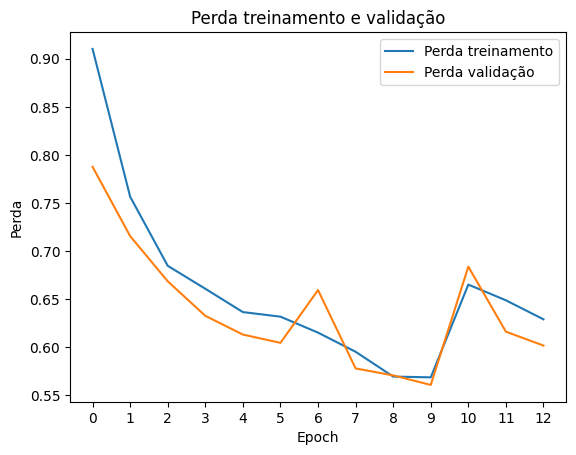

In [9]:
# Plota a perda (loss) e a perda de validação (val_loss) durante o treinamento
plt.plot(history.history['loss'], label='Perda treinamento')
plt.plot(history.history['val_loss'], label='Perda validação')
plt.title('Perda treinamento e validação')
plt.xlabel('Epoch')
plt.ylabel('Perda')
plt.xticks(range(len(history.history['loss'])))
plt.legend()
plt.show()

In [10]:
# Salva os arquivos
model.save('LSTMStacked_model.h5')
np.save("X_test_LSTMStacked.npy", X_test)
np.save("y_test_LSTMStacked.npy", y_test)